In [74]:
import sys
sys.path.append('/home/eric/srcs/FewShotSeg_Lab/FewShotVision_Lab/OEM-Few-Shot-Learnable-Prompt')

In [97]:
import argparse
import json
from data import OEMAdapterDataset, OEMAdapterDatasetV2

In [156]:
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image

In [121]:
import torch

In [130]:
config_path = "/home/eric/srcs/FewShotSeg_Lab/FewShotVision_Lab/OEM-Few-Shot-Learnable-Prompt/configs/adapter_10.json"

def get_args_parser(args=None):
    parser = argparse.ArgumentParser('SegGPT train adapter', add_help=False)
    parser.add_argument('--config', type=str, default=f'{config_path}', required=False)
    parser.add_argument('--port', type=int, help='DDP port', default=12355)
    parser.add_argument('--phase-2', action='store_true', help='phase 2 training, positive negative samples')
    parser.add_argument('--adapter-path', type=str, help='path to adapter checkpoint')
    parser.add_argument('--uid', type=str, help='unique id for the run', default=None)
    parser.add_argument('--lr', type=float, help='learning rate', default=None)
    parser.add_argument('--epoch', type=int, help='epoch', default=None)
    parser.add_argument('--ckpt-interval', type=int, help='checkpoint interval (in epoch)', default=None)
    return parser.parse_args([])

In [131]:
args = get_args_parser([])

In [132]:
args.config

'/home/eric/srcs/FewShotSeg_Lab/FewShotVision_Lab/OEM-Few-Shot-Learnable-Prompt/configs/adapter_10.json'

In [133]:
args.phase_2

False

In [134]:
train_args = json.load(open(args.config, 'r'))
train_args['adapter_path'] = args.adapter_path
train_args['phase_2'] = args.phase_2
if args.uid is not None:
    train_args['uid'] = args.uid
if args.lr is not None:
    train_args['lr'] = args.lr
if args.epoch is not None:
    train_args['epoch'] = args.epoch
if args.ckpt_interval is not None:
    train_args['ckpt_interval'] = args.ckpt_interval

In [135]:
train_dataset = OEMAdapterDatasetV2(
    root = train_args['train_dataset_dir'],
    mean = train_args['image_mean'],
    std = train_args['image_std'],
    resize = (1024, 1024),
    smallest_crop_size=train_args['smallest_crop_size'], 
    biggest_crop_size=train_args['biggest_crop_size'],
    smallest_stride=train_args['smallest_stride'],
    is_train=True,
    is_phase_2=train_args['phase_2'],
)

Caching images and grouping labels: 100%|██████████| 5/5 [00:00<00:00, 77.87it/s]


filename /home/eric/data/valset/10/images/duesseldorf_15.tif
filename /home/eric/data/valset/10/labels/duesseldorf_15.tif
filename /home/eric/data/valset/10/images/christchurch_39.tif
filename /home/eric/data/valset/10/labels/christchurch_39.tif
filename /home/eric/data/valset/10/images/kitsap_22.tif
filename /home/eric/data/valset/10/labels/kitsap_22.tif
filename /home/eric/data/valset/10/images/sechura_37.tif
filename /home/eric/data/valset/10/labels/sechura_37.tif
filename /home/eric/data/valset/10/images/sechura_11.tif
filename /home/eric/data/valset/10/labels/sechura_11.tif


Crop size: 256, stride: 64: 5it [00:00, 159.70it/s]
Crop size: 512, stride: 128: 5it [00:00, 422.29it/s]


In [136]:
def torch_denormalize(img):
    img[0,:]  =  (img[0,:]* 0.229) + 0.485
    img[1,:]  =  (img[1,:]* 0.224) + 0.456
    img[2,:]  =  (img[2,:]* 0.225) + 0.406
    return img   

def torch_display(image,batch,denormal):
    '''
    input shape : batch or not  
    
    torch.Size([batch, channel, 256, 256])
    '''
    img = image.clone() 
    if batch:
        img = img[0,:]
    else:
        pass
    
    #----- denormalizing func
    if denormal:
        # [0.485, 0.456, 0.406], [0.229, 0.224, 0.225]
        img = torch_denormalize(img)
    #-----
             
    img = img.permute(1,2,0)
    img = np.asarray(img)   
    
    fig_size= (10,10)
    plt.figure(figsize=fig_size)
    plt.imshow(img)

In [143]:
img, label, mask, valid, seg_type, ori_label, color_palette = train_dataset.__getitem__(5)

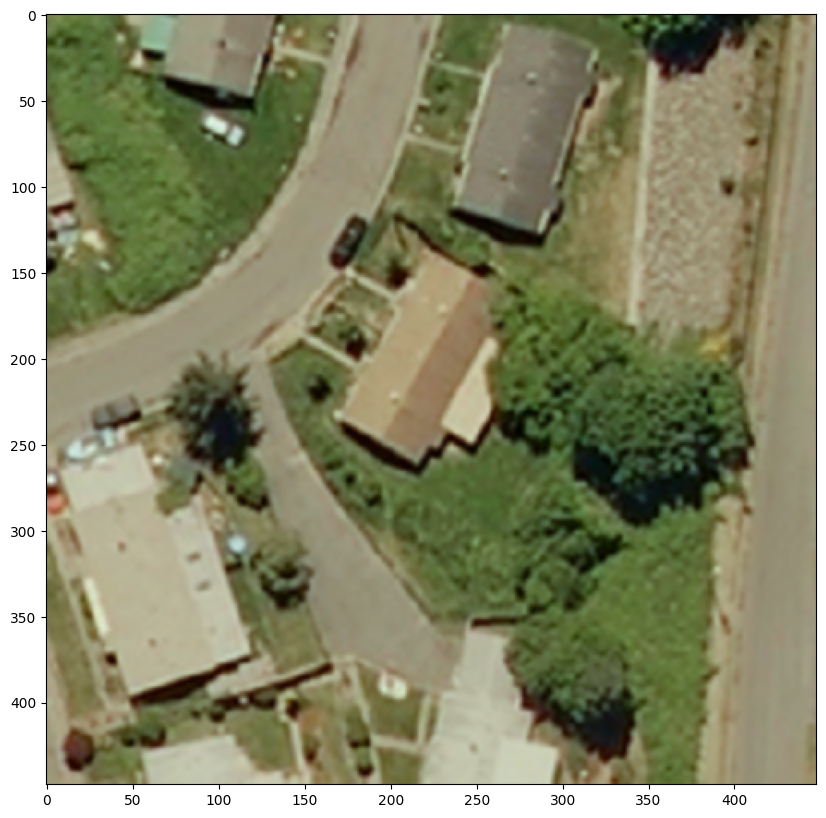

In [144]:
torch_display(img,False,True)

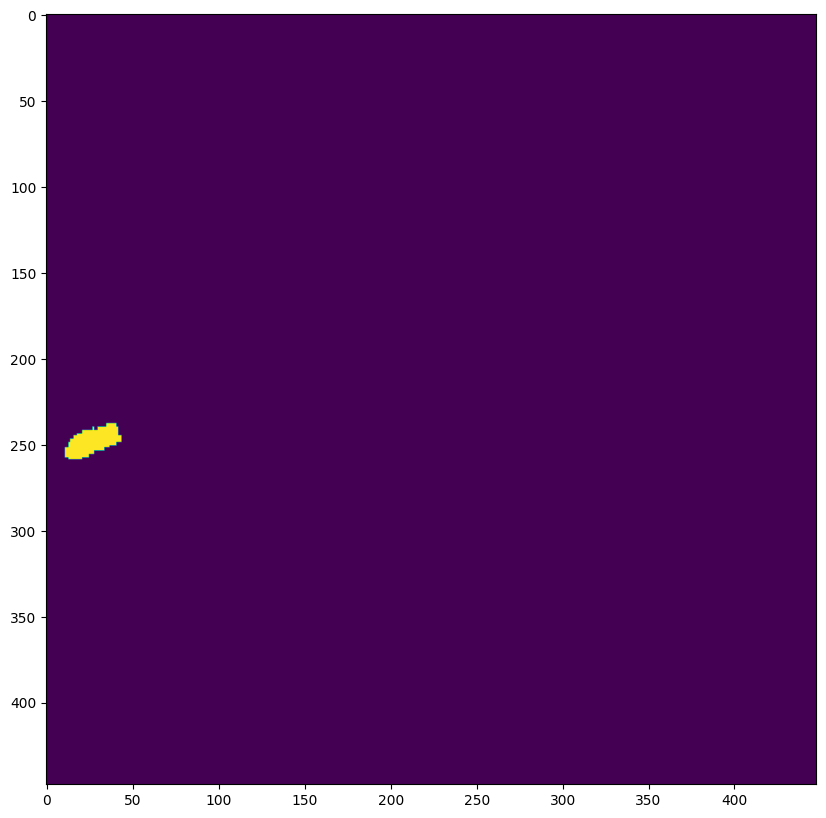

In [145]:
torch_display(ori_label.unsqueeze(0),False,False)

In [123]:
torch.unique(ori_label)

tensor([0., 1.])

In [155]:
tif_path = "/home/eric/data/valset/10/images/christchurch_39.tif"

In [158]:
aa = Image.open(tif_path).convert('RGB')

filename /home/eric/data/valset/10/images/christchurch_39.tif


In [160]:
aa.size

(1024, 1024)